Manuela & Sebastian <br>
Site Remediation CIVE686 <br>

**Objective**

The main objective of this report is exploring how can bioremediation (air sparging) be used on the Elizabeth City, NC site to clean up the concentration of TCE while tracking the degradation products and microbial growth.

**Assumptions**
- We are assuming that the maximum depth the TCE has reached is 35m as below that depth there is bedrock.
- Assuming no sorption given that there is just sand which is composed mainly by silica and the organic matter can be negligible.
- The concentration after the barrier should be 10$\%$ of the initial concentration.

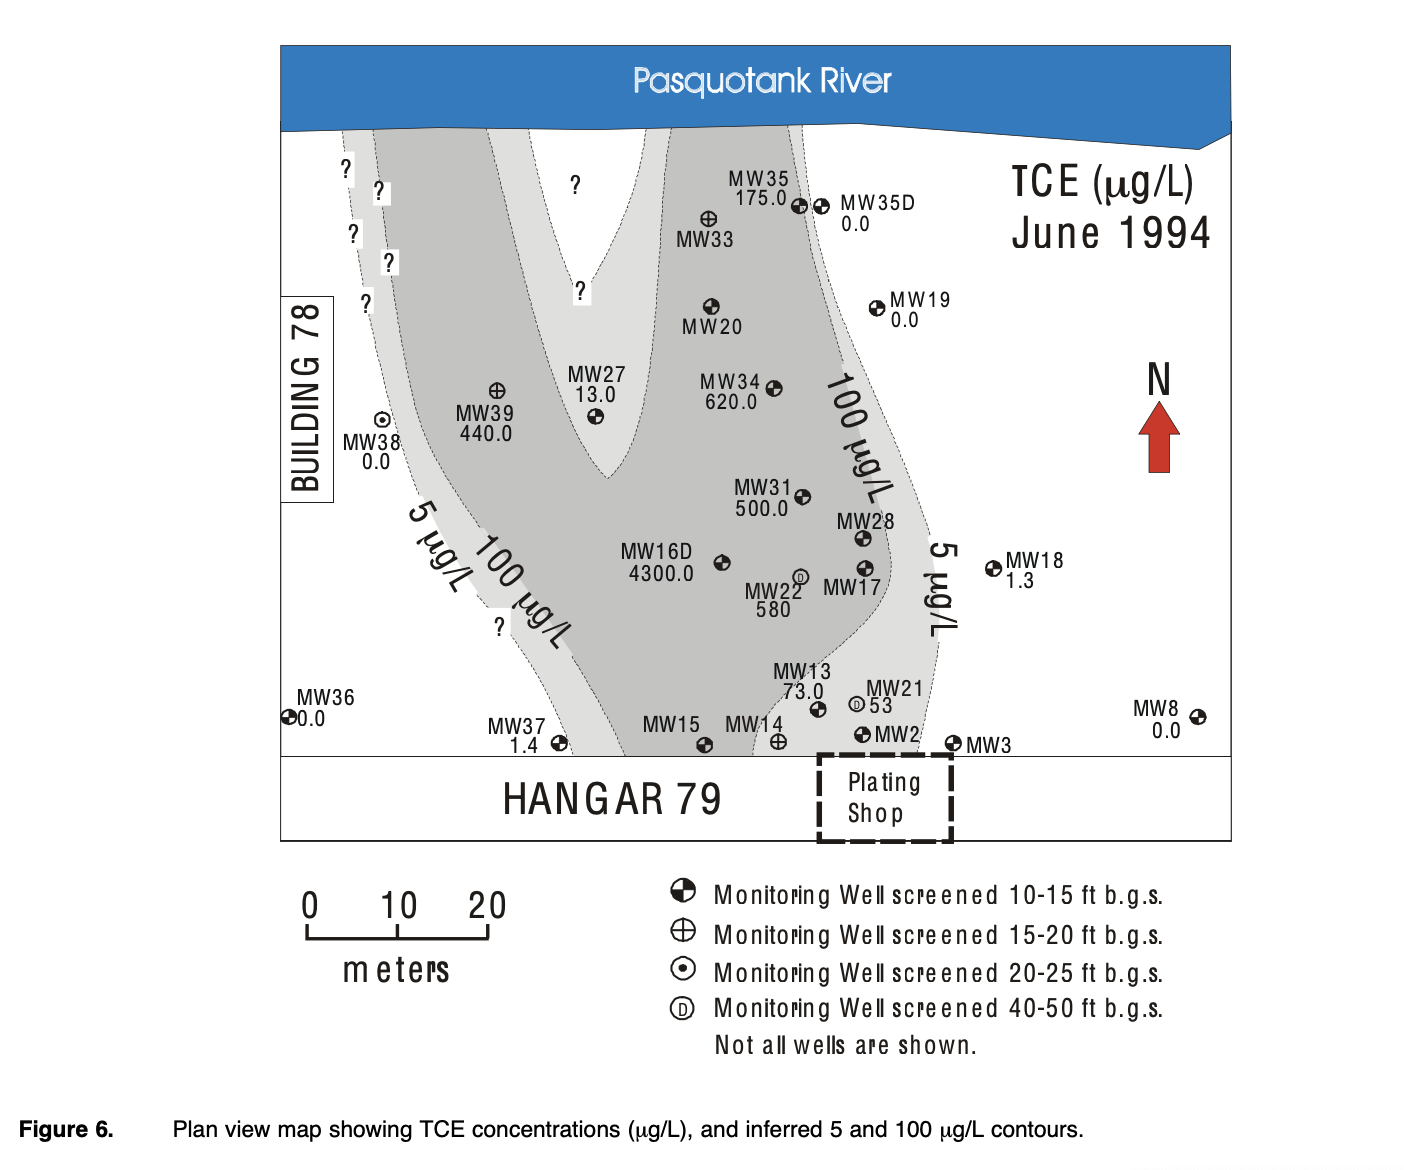
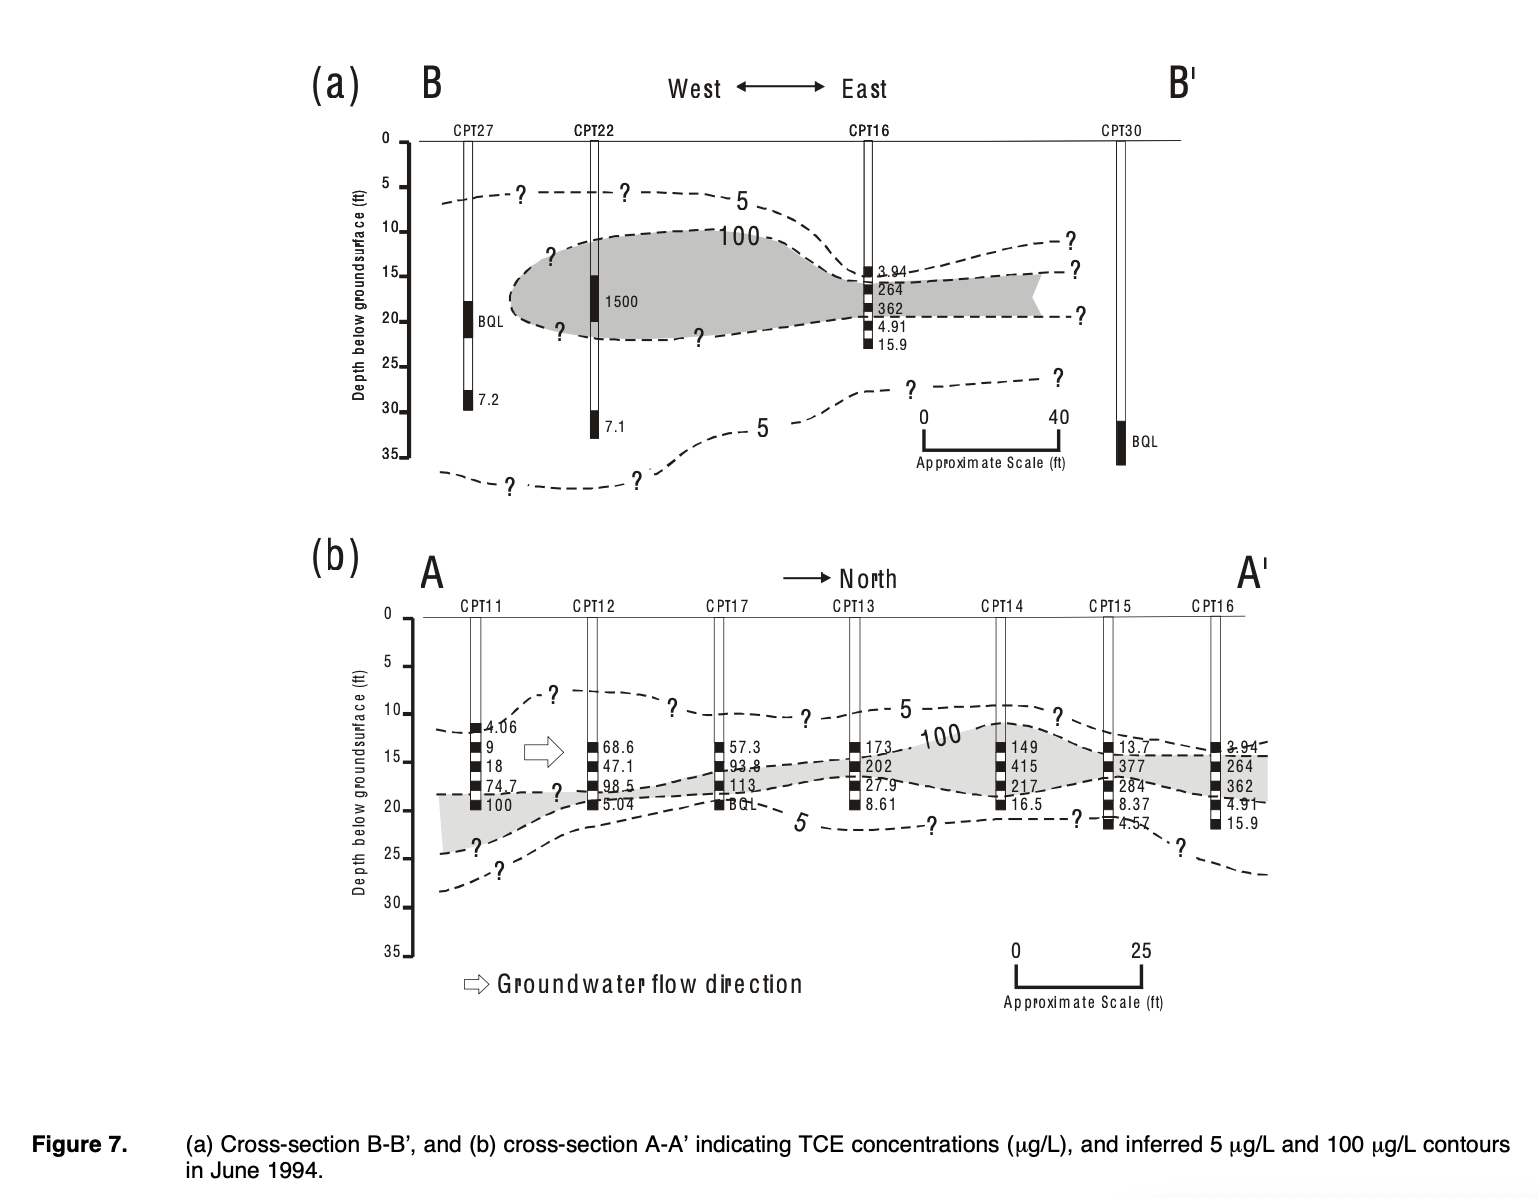
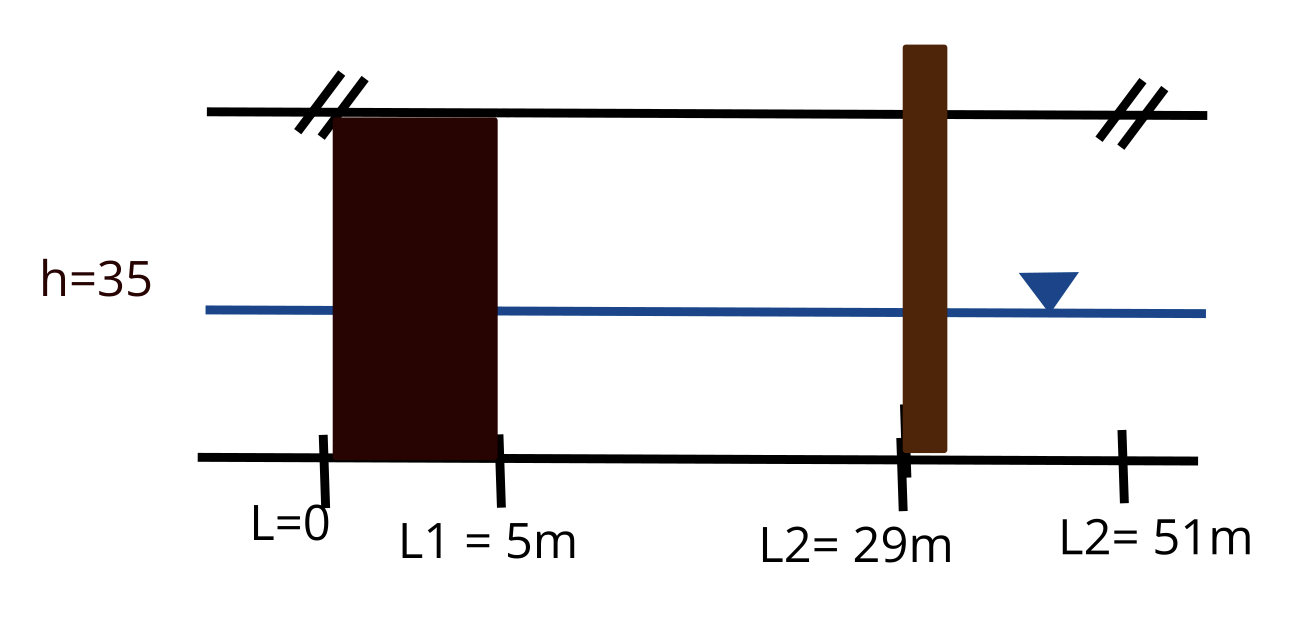

Main equation from L=0 to L=5m
$$    \frac{d C}{dt} = -v_x \frac{dC}{dx} + D_x \frac{d^2C}{dx^2} + k \frac{A}{V} (C_eq - C) $$
Consider the mass depleted from NAPL in $\triangle t$
$$ \frac{dM}{dt} = V \cdot \frac{dC}{dt} = v_{air} \frac{K_i A}{v} (C_eq - C)$$

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
num_wells = 1
L1 = 5 #5m
L2 = 29 #m
L3 = 51 #m
# consider a grid with 
delta_x = 0.5 #m  one grid pont each delta_x meters
delta_t = 0.01 #ne time step each delta_t days
num_lines_depth = 35 # basically in how many strips I want to split the 
# whole area
k_micro = 0.5e-3 # would be the same as k1
# How long do you want to run it?
total_time = 100 # days
total_grid_points = int(np.ceil(L3//delta_x))
total_time_points = int(np.ceil(total_time//delta_t))
# using the 1D contaminant approach
tce_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of DCE
dce_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of VC
vc_mat= np.zeros(( total_grid_points, total_time_points))

# Mass matrix
tce_mass_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of DCE
dce_mass_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of VC
vc_mass_mat= np.zeros(( total_grid_points, total_time_points))

# set some boundary conditions, we are assuming an initial concentration of 100mu g/L
co_TCE = 100e-6 # mg/L 
# Matrix of TCE
tce_mat[1:-1, 0] = co_TCE
# The concentration at the segment with NAPl is going to be given by the mass at each point 
depth = 35

b  = 1# width of site we can do per meter
n = 0.4# porosity of soil
rho_tce = 1.46 * (100)**3 #g/cm3 -> g/m^3
vol_NAPL = ((L1*b*depth)*n*0.01) # assuming half of the voids are filled with NAPL
total_mass_tce = vol_NAPL*rho_tce # g

mass_per_strip = total_mass_tce / num_lines_depth
mass_per_grid_point = mass_per_strip /(L1//delta_x)
delta_y = num_lines_depth/depth
# [0.43, 0.79]
v_x = 0.79 #m/day dayratio of linear travel distance and travel time

tce_mass_mat[1:total_grid_points -1, 0] = co_TCE*((delta_x*b*delta_y)*1000)
tce_mass_mat[1:int(L1//delta_x), 0] = mass_per_grid_point

# consider the section from 0 to L1 we only have dispersion and difussion as the
# main forces displacing our contaminant TCE, which is inside of a NAPL
aq_sol_TCE = 1.280 # g/L
k2 = 0.25e-3# first order constant of degradation

alpha = 1#m dispersivity coefficient
D_s = 0# D star or difussion coefficient
Dx = alpha * v_x + D_s
ktav = 25 #25.0 * (1/(24*3600)) # per day lumped mass transfer coefficient
v_soil_por = delta_x*delta_y*b*1000
v_por = n*delta_x*1000

tce_mat[1:int(L1//delta_x), 0] = min(mass_per_grid_point/((delta_x*b*delta_y)*1000), aq_sol_TCE)

R = (0.082 /1000) # m^3*atm/mol K
T = 298.15 # K
k_hy = 9.02e-2/(R*T)  # m^3 atm/mol henry constant fot TCE
Q_air = 10/(v_por) * 86400# m^3/s
#k_spa =  Q_air * k_hy
k_spa = 0.7
def safe_average_diff(curr, prev, next):
    # Avoid invalid operations
    if np.isnan(curr) or np.isnan(next) or np.isnan(prev):
        curr, next, prev = 0, 0, 0
    if np.isinf(curr) or np.isinf(next) or np.isinf(prev):
        curr, next, prev = 0, 0, 0
    dc_dx = (next - prev)/(2*delta_x)
    dc_dx_sq = (next - 2*curr + prev)/(delta_x**2)
    return dc_dx, dc_dx_sq

def compute_dc_dt_mass(curr, prev, next, pK):
    dc_dx, dc_dx_sq = safe_average_diff(curr, prev, next)
    return (-v_x*dc_dx + dc_dx_sq*Dx + pK*(aq_sol_TCE- curr))

def compute_dc_dt_bio(curr, prev, next):
    dc_dx, dc_dx_sq = safe_average_diff(curr, prev, next)
    return (-v_x*dc_dx + dc_dx_sq*Dx - (k_spa + k_micro)*(curr))  

def compute_dce_step(curr_dce, prev_dce, next_dce , curr_tce):
    x = 1#mole transfet coefficient
    k1 = k_micro # first order constant of degradation
    dc_dx, dc_dx_sq = safe_average_diff(curr_dce, prev_dce, next_dce)

    return -v_x*dc_dx + dc_dx_sq*Dx + x*k1*curr_tce - k2*curr_dce

def compute_vc_step(curr_vc, prev_vc, next_vc, curr_dce):
    y = 1#mole transfet coefficient
    k3 =  1.23e-4# first order constant of degradation
    dc_dx, dc_dx_sq = safe_average_diff(curr_vc, prev_vc, next_vc)

    return -v_x*dc_dx + dc_dx_sq*Dx  +y*k2*curr_dce - k3*curr_vc


for t in range(total_time_points - 1):
    for i in range(total_grid_points):
        if i <= int(L1//delta_x):
            dc_dt =  compute_dc_dt_mass(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i+ 1, t], ktav)  
            if i == 1:
                dc_dt = compute_dc_dt_mass(tce_mat[i, t], tce_mat[i+ 1, t], tce_mat[i+ 1, t], ktav)
            #elif i == (L1//delta_x):
            #    dc_dt = compute_dc_dt_mass(tce_mat[i, t], tce_mat[i - 1, t], tce_mat[i -  1, t], ktav)
                # update the mass matrix of TCE
            tce_mass_mat[i, t + 1] = tce_mass_mat[i, t] - delta_t*(dc_dt)*v_soil_por
            tce_mat[i, t + 1] = tce_mat[i, t] + delta_t*(dc_dt)
                #tce_mat[i, t + 1] =   min(tce_mass_mat[i, t + 1]/((delta_x*b*delta_y)*1000), aq_sol_TCE) # tce_mat[i, t] + dc_dt*delta_t
        elif i <= int(L2//delta_x):
            dc_dt = compute_dc_dt_mass(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i+ 1, t], 0)
            tce_mat[i, t + 1] = tce_mat[i, t] + dc_dt*delta_t
            # update the mass matrix of TCE
            tce_mass_mat[i, t + 1] = tce_mass_mat[i, t] - delta_t*(dc_dt)*v_soil_por
        elif i <= int(L3//delta_x):
            # athing beyond L2
            dc_dt = compute_dc_dt_bio(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i+ 1, t])
            dc_dt_dce = compute_dce_step(dce_mat[i, t], dce_mat[i - 1, t], dce_mat[i+ 1, t],  tce_mat[i, t])
            dc_dt_vc = compute_vc_step(vc_mat[i, t], vc_mat[i - 1, t], vc_mat[i +  1, t], dce_mat[i, t])
            if i == int(L3//delta_x):
                dc_dt = compute_dc_dt_bio(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i- 1, t])


            tce_mat[i, t + 1] = tce_mat[i, t] + dc_dt*delta_t
            dce_mat[i, t + 1] = dce_mat[i, t] + dc_dt_dce*delta_t
            vc_mat[i, t + 1] = vc_mat[i, t] + dc_dt_vc*delta_t 
            
            tce_mass_mat[i, t + 1] = tce_mass_mat[i, t] - dc_dt*v_por*delta_t
            dce_mass_mat[i, t +  1] = dce_mass_mat[i, t] -  dc_dt_dce*v_por*delta_t
            vc_mass_mat[i, t + 1] = dce_mass_mat[i, t] -  dc_dt_vc*v_por*delta_t

        tce_mat[0, t + 1] = 0 # concentration at the boundary doesn't change
        tce_mat[-1, t + 1] = 0
        tce_mass_mat[0, t+ 1] = 0
        tce_mass_mat[-1, t + 1] = 0
        
        index_l2 = int(L2//delta_x)
        dce_mat[index_l2, t + 1] = 0
        dce_mat[-1, t + 1] = 0
        dce_mass_mat[index_l2, t +  1] = 0
        dce_mass_mat[-1, t +  1] = 0

        vc_mat[index_l2, t + 1] = 0
        vc_mat[-1, t + 1] = 0
        vc_mass_mat[index_l2, t + 1] = 0
        vc_mass_mat[-1, t + 1] = 0

        tce_mass_mat[i, t + 1] = max(0, tce_mass_mat[i, t + 1])

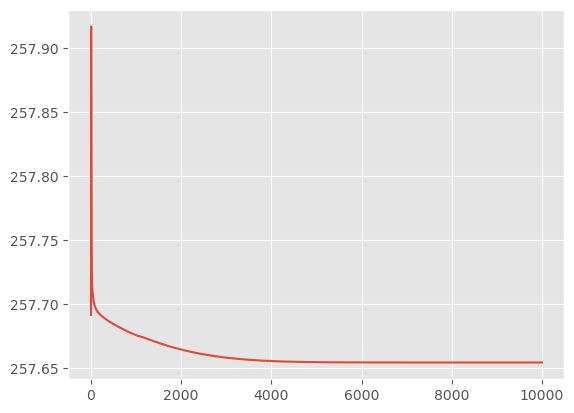

In [356]:
plt.plot(np.mean(tce_mass_mat, axis=0))


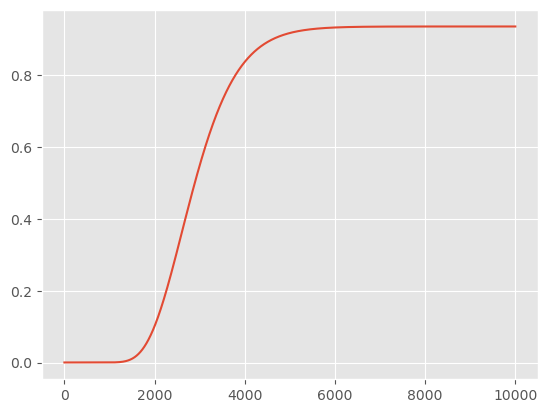

In [357]:
plt.plot(tce_mat[int(L2//delta_x), :])


In [354]:
tce_mat[:, -1]

array([0.00000000e+00, 1.28000000e+00, 1.28000000e+00, 1.28000000e+00,
       1.28000000e+00, 1.28000000e+00, 1.28000000e+00, 1.28000000e+00,
       1.28000000e+00, 1.28000000e+00, 1.28000000e+00, 1.28000000e+00,
       1.28000000e+00, 1.28000000e+00, 1.28000000e+00, 1.28000000e+00,
       1.28000000e+00, 1.28000000e+00, 1.28000000e+00, 1.28000000e+00,
       1.28000000e+00, 1.28000000e+00, 1.28000000e+00, 1.27999999e+00,
       1.27999999e+00, 1.27999998e+00, 1.27999997e+00, 1.27999995e+00,
       1.27999992e+00, 1.27999987e+00, 1.27999978e+00, 1.27999964e+00,
       1.27999941e+00, 1.27999901e+00, 1.27999836e+00, 1.27999727e+00,
       1.27999545e+00, 1.27999243e+00, 1.27998740e+00, 1.27997901e+00,
       1.27996503e+00, 1.27994173e+00, 1.27990291e+00, 1.27983823e+00,
       1.27973042e+00, 1.27955076e+00, 1.27925133e+00, 1.27875231e+00,
       1.27792063e+00, 1.27653452e+00, 1.27422436e+00, 1.27037414e+00,
       1.26395715e+00, 1.25326221e+00, 1.23543738e+00, 1.20572938e+00,
      

In [363]:
tce_mass_mat[:,3]

array([0.00000000e+00, 2.92000000e+03, 2.92000000e+03, 2.92000000e+03,
       2.92000000e+03, 2.92000000e+03, 2.92000000e+03, 2.92000852e+03,
       2.92074914e+03, 2.94234389e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
      

Text(0, 0.5, 'Average Mass TCE in NAPL [g]')

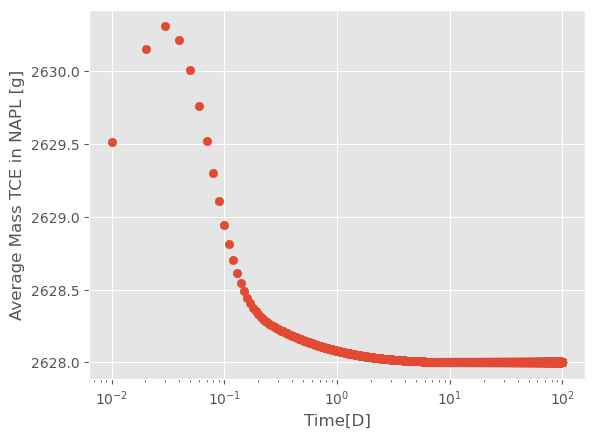

In [358]:
how_much = total_time_points

plt.scatter(np.linspace(0, total_time, how_much), np.nanmean(tce_mass_mat[:int(L1//delta_x),:how_much], axis=0))

#plt.ylim(1.378e8, np.mean(tce_mass_mat[:int(L1//delta_x),0]))

#plt.axhline(y=0, color='blue')
#plt.axvline(x=1e-1)
plt.xscale('log')

plt.xlabel("Time[D]")
plt.ylabel("Average Mass TCE in NAPL [g]")


In [198]:
delta_x*b*delta_y*1000

500.0

Text(0, 0.5, 'Average Mass TCE in NAPL [g]')

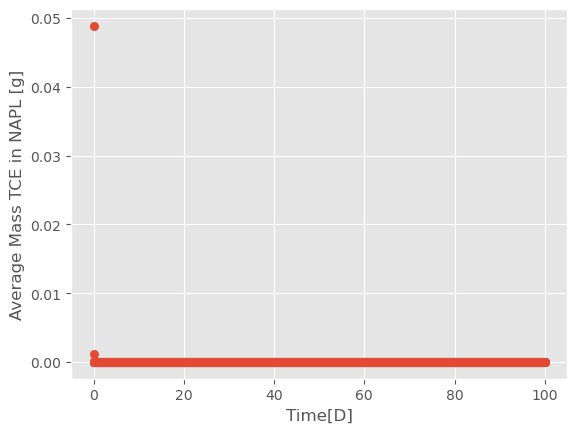

In [338]:
how_much = total_time_points

plt.scatter(np.linspace(0, total_time, how_much), np.nanmean(tce_mass_mat[int(L2//delta_x):,:how_much], axis=0))

#plt.ylim(1.378e8, np.mean(tce_mass_mat[:int(L1//delta_x),0]))


plt.xlabel("Time[D]")
plt.ylabel("Average Mass TCE in NAPL [g]")


In [200]:
tce_mass_mat[:, 1]

array([0.00000000e+00, 2.85600579e+03, 2.85600500e+03, 2.85600500e+03,
       2.85600500e+03, 2.85600500e+03, 2.85600500e+03, 2.85600500e+03,
       2.85600500e+03, 2.85600500e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [120]:
print(tce_mass_mat[:int(L1//delta_x) + 10, -1])

[   0.         2696.62022245 2668.17146291 2664.54866646 2664.08732283
 2664.0285732  2664.02109175 2664.02013903 2664.02001772 2664.02000242
 -255.97999758 -255.97999758 -255.97999758 -255.97999758 -255.97999758
 -255.97999758 -255.97999758 -255.97999757 -255.97999757 -255.97999756]


In [16]:
np.arange(total_time_points).shape

(10499,)

In [17]:
np.median(tce_mat[:int(L1//delta_x) + 10, :], axis=1)

array([0.        , 0.01095704, 0.02847549, 0.0556309 , 0.09646615,
       0.15559564, 0.23682764, 0.34037638, 0.4589368 , 0.57414584,
       0.62997554, 0.65681334, 0.6699372 , 0.67700233, 0.68118565,
       0.68418943, 0.68596605, 0.68645921, 0.68752749, 0.68776654])

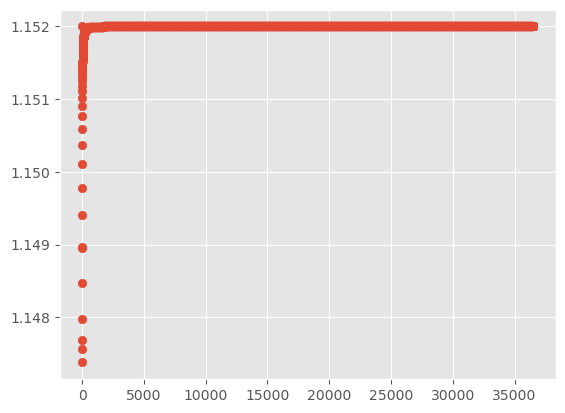

In [319]:
plt.scatter(np.arange(total_time_points), np.mean(tce_mat[:int(L1//delta_x), :], axis=0))

In [19]:
max_delta_t = delta_x**2 / (2 * Dx)
print(f"Max stable delta_t: {max_delta_t}")

Max stable delta_t: 0.1582278481012658


In [312]:
frames = total_time_points//20
anim_mass = np.zeros((num_lines_depth, total_grid_points, frames))
print(anim_mass.shape)
t = 1
index = 0
for t in range(0, total_time_points, frames):
    ls = []
    for i in range(num_lines_depth):
        ls.append(np.copy(tce_mass_mat[:, t]))

    anim_mass[:, :, index]  = np.stack(ls)
    index += 1
    #plt.show()



(35, 102, 524)


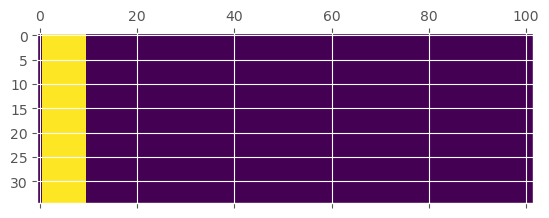

In [313]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

scat = ax.matshow(np.stack(ls))
x = np.array(range(0, total_time_points, frames))

def animate(i):
    ax.matshow(anim_mass[:, :, i])
    return scat,


ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(x) - 1)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=7,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
ani.save('scatter.gif', writer=writer)

(35, 102, 499)


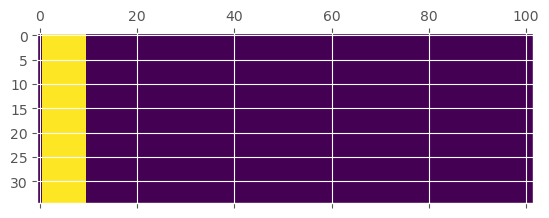

In [339]:
frames = total_time_points//20
anim_mass = np.zeros((num_lines_depth, total_grid_points, frames))
print(anim_mass.shape)
t = 1
index = 0
for t in range(0, total_time_points, frames):
    ls = []
    for i in range(num_lines_depth):
        ls.append(np.copy(tce_mat[:, t]))

    anim_mass[:, :, index]  = np.stack(ls)
    index += 1
    #plt.show()



fig, ax = plt.subplots()

scat = ax.matshow(np.stack(ls))
x = np.array(range(0, total_time_points, frames))

def animate(i):
    ax.matshow(anim_mass[:, :, i])
    return scat,


ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(x) - 1)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=7,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
ani.save('concentration_over_time.gif', writer=writer)

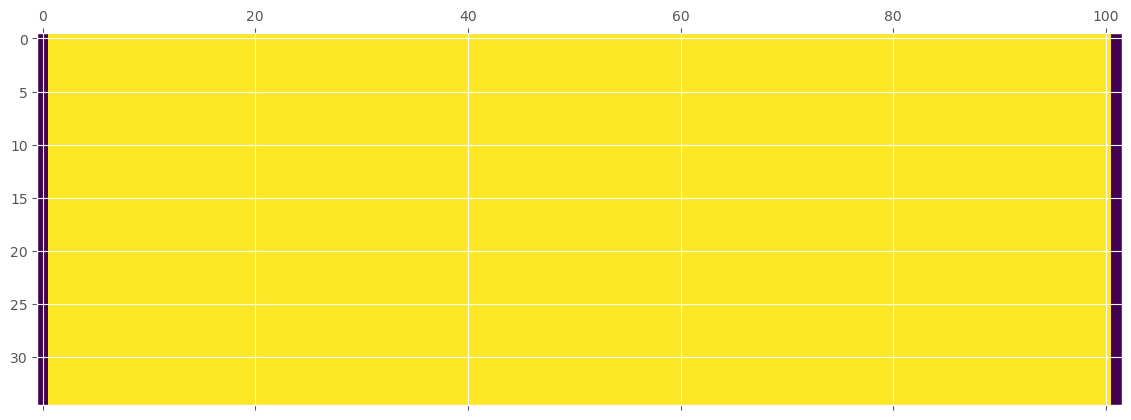

In [41]:
plt.matshow(anim_mass[:, :, 0])

In [30]:
for t in range(total_grid_points, 20):
    plt.scatter(np.arange(total_grid_points), tce_mat[:, -t])
    plt.show()

0


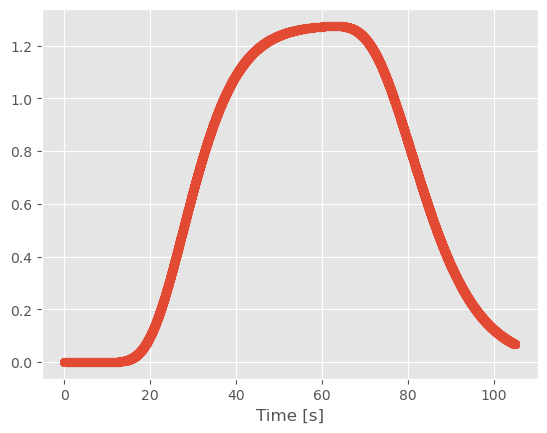

In [32]:
normalized_x = np.linspace(0, L3, total_grid_points)
plt.scatter(np.linspace(0, total_time, total_time_points), tce_mat[int(L2//delta_x), :])
plt.xlabel("Time [s]")
print(k_spa)

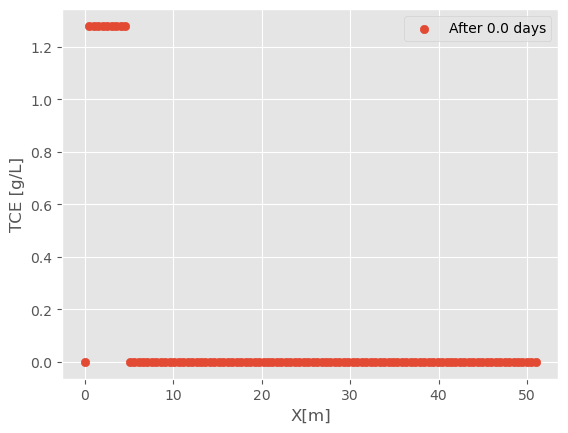

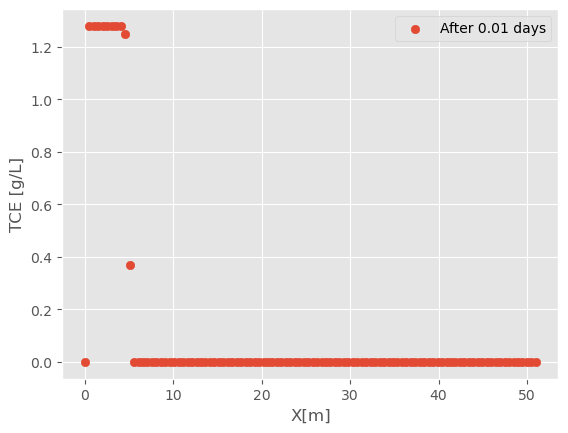

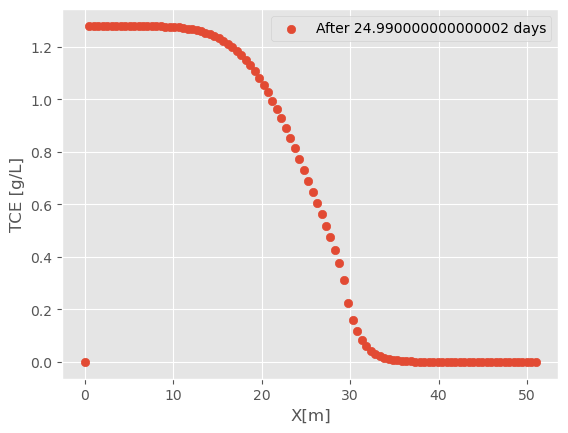

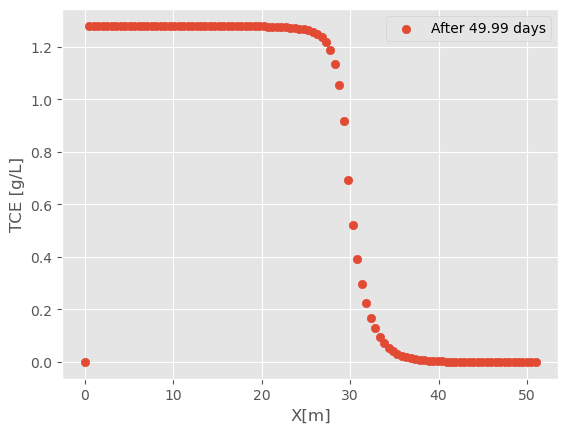

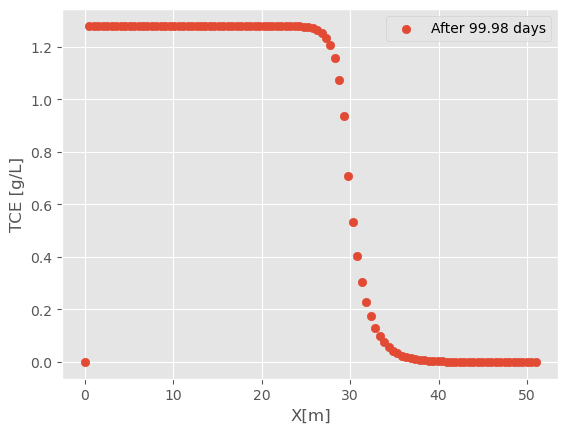

In [344]:
for t in [0, 1, total_time_points//4, total_time_points//2, total_time_points - 1]:
    plt.scatter(normalized_x, tce_mat[:, t ], label=f"After {t*delta_t} days")
    plt.xlabel("X[m]")
    plt.ylabel("TCE [g/L]")
    plt.legend()
    plt.show()

# 0.000025 g/L

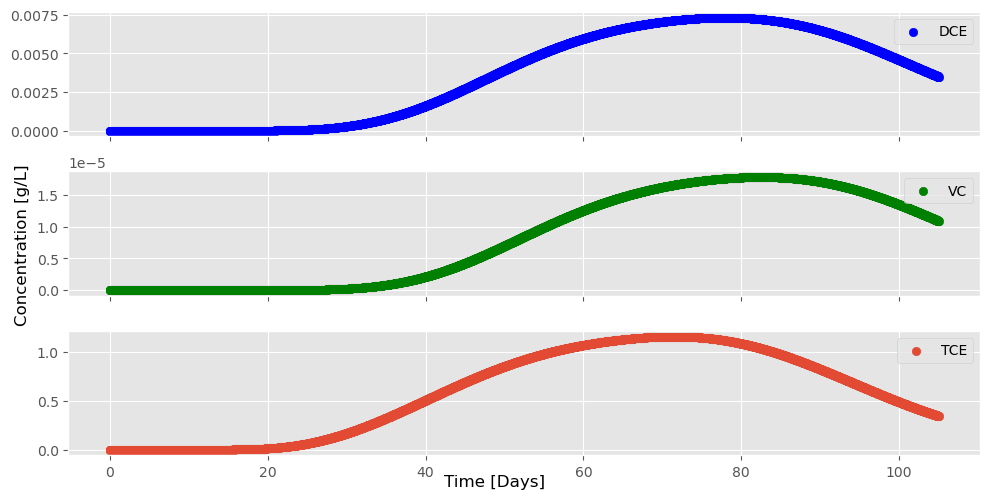

In [78]:
start_point= int(L2//delta_x)

f, ((ax1), (ax2), (ax3)) = plt.subplots(nrows=3, ncols=1, figsize=(10, 5), sharex=True)
normalized_time = np.linspace(0, total_time, total_time_points)
ax1.scatter(normalized_time, np.mean(dce_mat[start_point:,  :], axis=0), label='DCE', color='blue')
ax2.scatter(normalized_time, np.mean(vc_mat[start_point:,  :], axis=0), label='VC', color='green')
ax3.scatter(normalized_time, np.mean(tce_mat[start_point:,  :], axis=0), label='TCE')
ax1.legend()
ax2.legend()
ax3.legend()
plt.tight_layout()

f.supylabel('Concentration [g/L]')
f.supxlabel('Time [Days]')

plt.show()

In [ ]:
L3//delta_x